In [239]:
import numpy as np

# Generate a distribution

nDistFeat = 2
nFeat = 1
nTotFeat = nDistFeat + nFeat

nSamp = 100
uncor = np.array([1],dtype='int')
mu = np.random.randn(nTotFeat)
r = np.random.randn(nTotFeat,nTotFeat)
r = r@r.T
print(r)
x = np.random.multivariate_normal(mu, r, size=nSamp)
x[:,uncor] = np.random.randn(nSamp,uncor.shape[0])
y = x[:,nDistFeat:]
x = x[:,:nDistFeat]

print(x.shape)
print(y.shape)

[[ 1.46609743  2.22924328  0.31804008]
 [ 2.22924328  7.73956552 -1.28141612]
 [ 0.31804008 -1.28141612  0.78596155]]
(100, 2)
(100, 1)


In [240]:
print(x[0:2])
print(y[0:2])

[[ 1.32425962  0.45066842]
 [-0.72366094  0.93835438]]
[[0.17992409]
 [1.04694801]]


In [241]:
import torch
import torch.nn as nn
import torch.nn.functional as F

x_t = torch.from_numpy(x).float()
y_t = torch.from_numpy(y).float()

nHidFeat = 10
nHid = 10
nLayers = 3

def normalize(A):
    if A.shape[0] != A.shape[1]:
        raise Exception("Bad A shape")
    d = torch.sum(torch.abs(A),dim=1)**0.5
    A = ((A/d).T/d).T
#     A *= 1-torch.eye(A.shape[0])
#     A += torch.eye(A.shape[0])
    return A

def calcEdges(x1,x2,m1,m2):
    mx1 = torch.einsum('ai,i->ai',x1,m1)
    mx2 = torch.einsum('ai,i->ai',x2,m2)
#     e = torch.einsum('ai,bi->ab',mx1,mx2)
#     nmx1 = torch.einsum('ai,ai->a',mx1,mx1)**0.5
#     nmx2 = torch.einsum('ai,ai->a',mx2,mx2)**0.5
#     e /= nmx1.unsqueeze(1)
#     e /= nmx2.unsqueeze(1).T
    e = 1/(torch.cdist(mx1,mx2)+1)
    return normalize(e)

def gcn(layers, edges, feat, idx):
    h = [None]*(nLayers+1)
#     s = torch.einsum('abc->ac',edges).unsqueeze(1)
    h[0] = feat
    
    for i in range(1,nLayers+1):
        h[i] = torch.einsum('ab,bf->af',edges,h[i-1])
#         h[i] /= s
#         h[i] = h[i].reshape(feat.shape[0],-1)
#         h[i] = F.relu(layers[i-1](h[i]))
    
    return torch.cat(h[1:], dim=1)

class Sim1(nn.Module):
    def __init__(self):
        super(Sim1, self).__init__()
        self.mask = nn.Parameter(torch.zeros(nDistFeat))
        self.l1 = nn.Linear(nFeat,nHidFeat)
        self.l2 = nn.Linear(nHidFeat,nHidFeat)
        self.l3 = nn.Linear(nHidFeat,nHidFeat)
        self.ls = [self.l1,self.l2,self.l3]
        
        self.fc1 = nn.Linear(nFeat*nLayers,nHid)
        self.fc2 = nn.Linear(nHid,1)
        
    def forward(self, x):
        trainNotTest = x[0]
        
        m = torch.sigmoid(self.mask)
        
        if trainNotTest:
            idcs = x[1]
            
            # Edges
            e = calcEdges(self.p,self.p,m,m)
            
            # Feat
            h = []
            
            for i in idcs:
                feat = self.feat.detach().clone()
                feat[i] = 0
                h.append(gcn(self.ls, e, feat, i)[i])
                
            h = torch.stack(h)
        else:
            ap = x[1]
            of = x[2].detach().clone()
            
            # Feat
            h = []
            
            for i in len(ap):
                p = torch.cat(ap[i], self.p)
                
                # Edges
                e = calcEdges(p,p,m,m)
                
                # Feat
                feat = torch.cat([of[i:i+1], self.feat])
                feat[0,0] = 0   
                h.append(gcn(self.ls, e, feat, 0)[0])
            
            h = torch.stack(h)
            
        x = F.relu(self.fc1(h))
        x = self.fc2(x)
        return x
    
sim1 = Sim1()
optim = torch.optim.Adam(sim1.parameters(), lr=1e-3)
print('Complete')

Parameter containing:
tensor([0., 0.], requires_grad=True)
Complete


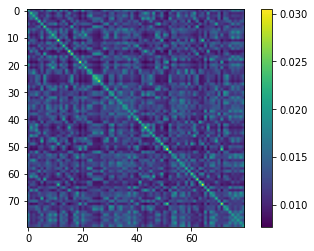

In [242]:
import matplotlib.pyplot as plt

m = torch.sigmoid(sim1.mask)
p = x_t[0:80]
e = calcEdges(p,p,m,m)

plt.imshow(e.detach().numpy())
plt.colorbar()
plt.show()

In [243]:
import random

N = 80
running = 0
runningM = 0
nEpoch = 1000
pPeriod = 100
nBatch = 10
thresh = 0.01
mThresh = 1

sim1.p = x_t[0:80]
sim1.feat = y_t[0:80]

for epoch in range(nEpoch):
    batch = []
    truth = torch.zeros(nBatch)
    for i in range(nBatch):
        idx = random.randint(0,N-1)
        batch.append(idx)
        truth[i] = y_t[idx,0]
    optim.zero_grad()
    pred = sim1([True, batch])
    # Label loss
    l0 = torch.sum((truth-pred.flatten())**2)
    # Mask loss
    l1 = torch.sum(torch.exp(-(sim1.mask**2)/10))
    running += l0.detach().cpu()
    runningM += l1.detach().cpu()
    # Total loss
    loss = l0+l1
    loss.backward()
    optim.step()
    if epoch % pPeriod == 0 or epoch == nEpoch-1:
        if epoch != 0:
            if epoch % pPeriod != 0:
                running /= epoch % pPeriod
                runningM /= epoch % pPeriod
            else:
                running /= pPeriod
                runningM /= pPeriod
        print('epoch {:d} loss={:f} mLoss={:f}'.format(epoch, running/nBatch, runningM))
        if running/nBatch < thresh and runningM < mThresh:
            break
        running = 0
        runningM = 0

print('Finished training')

epoch 0 loss=0.722822 mLoss=2.000000
epoch 100 loss=1.289400 mLoss=1.999846
epoch 200 loss=0.844691 mLoss=1.998238
epoch 300 loss=0.759628 mLoss=1.991758
epoch 400 loss=0.740870 mLoss=1.975631
epoch 500 loss=0.735067 mLoss=1.947548
epoch 600 loss=0.747861 mLoss=1.908300
epoch 700 loss=0.698459 mLoss=1.859889
epoch 800 loss=0.732195 mLoss=1.804245
epoch 900 loss=0.706588 mLoss=1.743245
epoch 999 loss=0.700729 mLoss=1.678399
Finished training


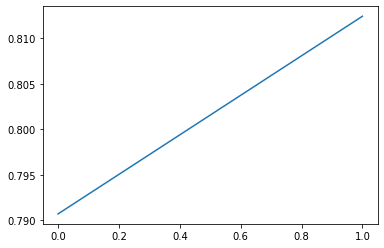

In [244]:
m = torch.sigmoid(sim1.mask).detach().numpy()

plt.plot(m)
plt.show()

[[ 1.         -0.21341262]
 [-0.21341262  1.        ]]
0.8482618287034968
0.6984135627746582


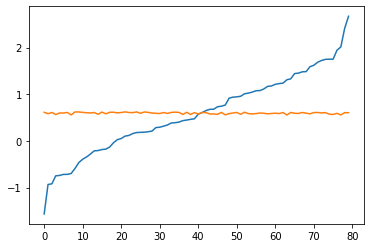

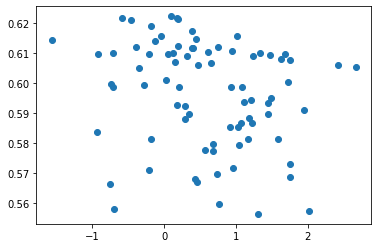

In [245]:
import matplotlib.pyplot as plt
import math

y = y_t[0:80].detach().numpy().flatten()
idcs = torch.arange(0,len(y))
yPred = sim1([True, idcs]).detach().numpy().flatten()
    
idcs = np.argsort(y)
yPred = yPred[idcs]
y = y[idcs]

corr = np.corrcoef(y, yPred)
rmse = (np.sum((y-yPred)**2)/len(y))**0.5
mae = np.sum(np.abs(y-yPred))/len(y)

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(yPred, label='Prediction')
plt.show()

plt.scatter(y, yPred)
plt.show()